# Multiscale deblending tutorial

The idea behind deblending with wavelets is that in theory it should be easier to separate high frequency signals from low frequency signals, since sources are less blended a higher frequencies (the center of most astrophysical sources). In this tutorial two different types of wavelet deblending are attempted, as described below. But first we show the results using the current version of scarlet. This also serves as an example of how to implement your own deblending schemes using scarlet lite.

In [1]:
# Import Packages and setup
import logging
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)
logger = logging.getLogger("proxmin")
logger.setLevel(logging.DEBUG)

import time
from functools import partial
import numpy as np
import scarlet
import scarlet.display
from scarlet.display import AsinhMapping, img_to_rgb
from scarlet.operator import prox_monotonic_mask
from scarlet.operators_pybind11 import get_valid_monotonic_pixels, linear_interpolate_invalid_pixels
from scarlet.detect import get_detect_wavelets, get_blend_structures, bounds_to_bbox, get_peaks
from scarlet.wavelet import (starlet_transform, get_multiresolution_support, starlet_reconstruction,
                             multiband_starlet_transform, multiband_starlet_reconstruction)
from scarlet.lite import LiteObservation, integrated_circular_gaussian, parameterize_sources, LiteBlend
from scarlet.lite import init_adaprox_component, init_fista_component

from astropy.table import Table as ApTable

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', interpolation='none', origin="lower")
prop_cycle = [c["color"] for c in plt.rcParams['axes.prop_cycle']]


def display_multiresolution_residuals(images, mask, blend, scales=3, stretch=0.2, Q=10, generation=1):
    """This function just displays the residual in each wavelet scale
    """
    # Calculate the ratio of the height/width, used for layout
    ratio = images.shape[-2] / images.shape[-1]
    
    # Load the unconvolved model
    model = blend.get_model(convolve=False)
    

    # Display the original image and the model
    norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7.5*ratio))
    rgb = scarlet.display.img_to_rgb(images, norm=norm, mask=mask)
    ax[0].imshow(rgb)
    ax[0].set_title("image")
    rgb = scarlet.display.img_to_rgb(blend.observation.convolve(model), norm=norm, mask=mask)
    ax[1].imshow(rgb)
    ax[1].set_title("convolved model")
    
    for center in centers:
        ax[0].plot(center[1], center[0], "rx")
        ax[1].plot(center[1], center[0], "rx")
    plt.show()

    # Calculate the wavelet coefficients of the image and the model
    w1 = multiband_starlet_transform(images, scales=scales, generation=generation)
    w2 = multiband_starlet_transform(model, scales=scales, generation=generation)

    # Convolve the wavelet coefficients in each band
    c2 = w2.copy()
    for s in range(scales+1):
        c2[s] = observation.convolve(c2[s])

    # Calculate the residual for all wavelet scales
    residual = w1 - c2
    # Display the image, model, and residual, at each wavelet scale
    norm = AsinhMapping(minimum=np.min(images), stretch=stretch, Q=Q)
    for s in range(scales + 1):
        fig, ax = plt.subplots(1, 4, figsize=(20, 5*ratio))
        rgb = scarlet.display.img_to_rgb(w2[s], norm=norm, mask=mask)
        ax[0].imshow(rgb)
        rgb = scarlet.display.img_to_rgb(w1[s], norm=norm, mask=mask)
        ax[1].imshow(rgb)
        rgb = scarlet.display.img_to_rgb(c2[s], norm=norm, mask=mask)
        ax[2].imshow(rgb)
        rgb = scarlet.display.img_to_rgb(residual[s], mask=mask)
        ax[3].imshow(rgb)
        for center in centers:
            ax[3].plot(center[1], center[0], "rx")
        for src in blend.sources:
            if src.is_null:
                continue
            ax[3].plot(src.center[1], src.center[0], "gx")
        plt.show()

## Load a test dataset

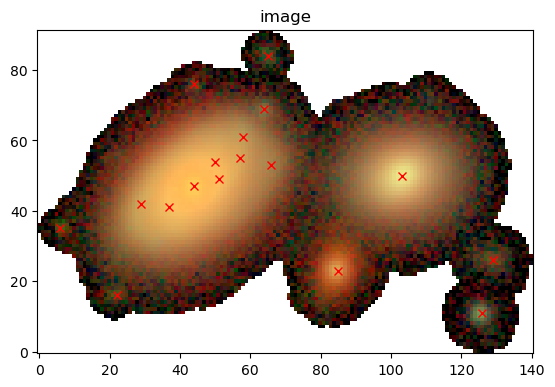

In [2]:
data = np.load("testdata_3_0.npz")

images = data["images"]
variance = data["variance"]
weights = 1/data["variance"]
mask = data["footprint"]
weights = weights * ~mask
psfs = data["psfs"]
centers = data["centers"]

ratio = images.shape[-2] / images.shape[-1]

# Use wavelet detection to detect more sources
detect = get_detect_wavelets(images, variance, scales=5)
centers = np.array(list(get_peaks(detect*~mask[None, :, :])))

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
rgb = scarlet.display.img_to_rgb(images, norm=norm, mask=mask)
plt.imshow(rgb)
for center in centers:
    plt.plot(center[1], center[0], "rx")
plt.title("image")
plt.show()

# Vanilla scarlet lite

We first use the standard scarlet lite code to measure both the runtime and overall -logL (smaller is better):

/usr/local/lib/python3.8/dist-packages/scarlet-1.0.1+g11d1363-py3.8-linux-x86_64.egg/scarlet/lite/models.py:119: RuntimeWarning: invalid value encountered in true_divide
  if np.any(edge_flux/edge_mask > self.bg_thresh*self.bg_rms[:, None, None]):
/usr/local/lib/python3.8/dist-packages/scarlet-1.0.1+g11d1363-py3.8-linux-x86_64.egg/scarlet/lite/measure.py:85: RuntimeWarning: divide by zero encountered in true_divide
  ratio = numerator / denominator
/usr/local/lib/python3.8/dist-packages/scarlet-1.0.1+g11d1363-py3.8-linux-x86_64.egg/scarlet/lite/measure.py:85: RuntimeWarning: invalid value encountered in true_divide
  ratio = numerator / denominator


CPU times: user 6.33 s, sys: 857 ms, total: 7.19 s
Wall time: 6.14 s
100 iterations to a final -logL of 21252


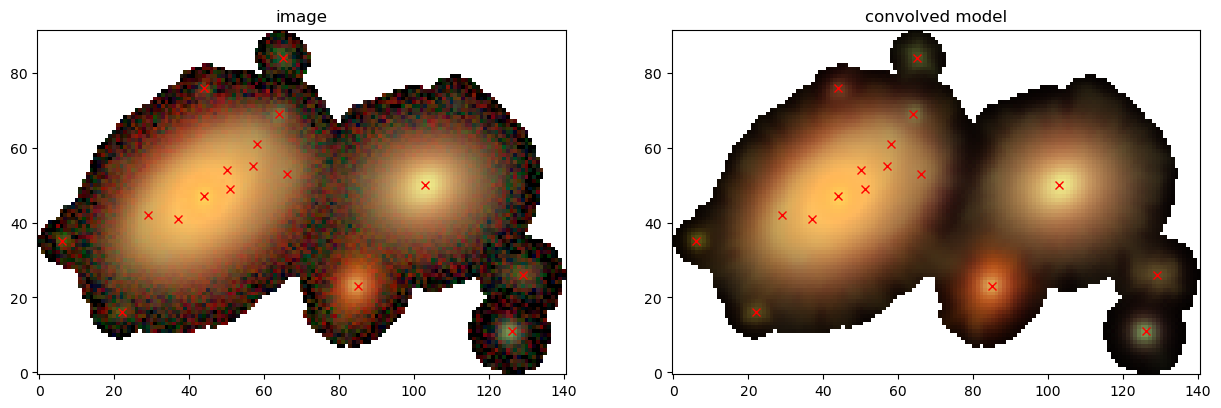

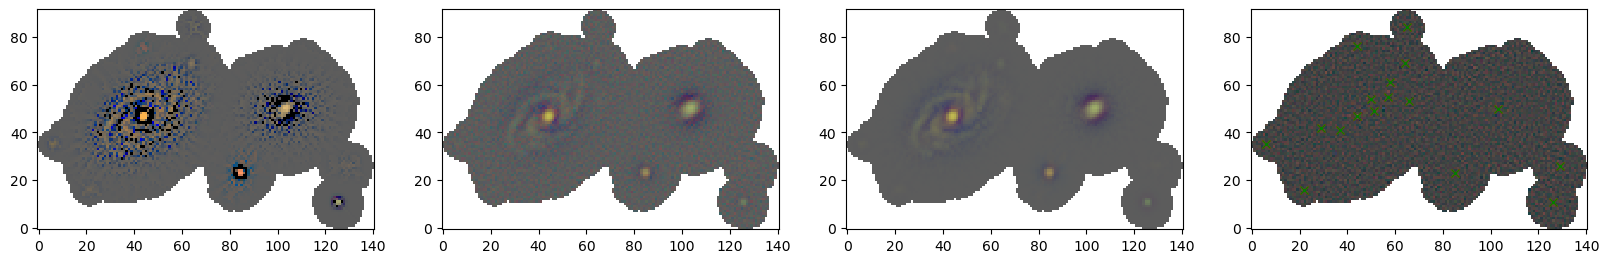

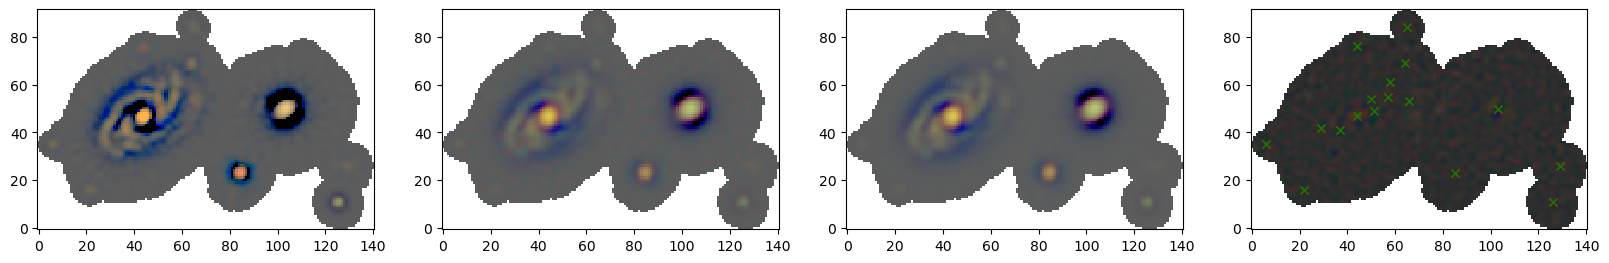

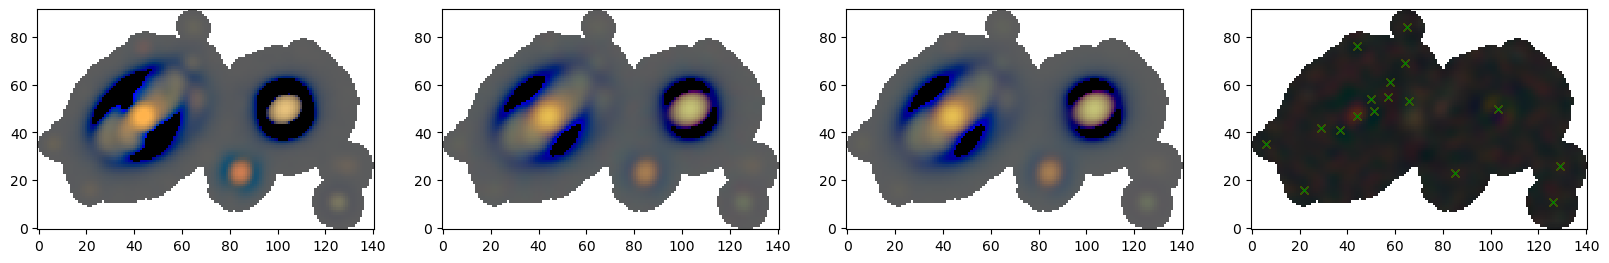

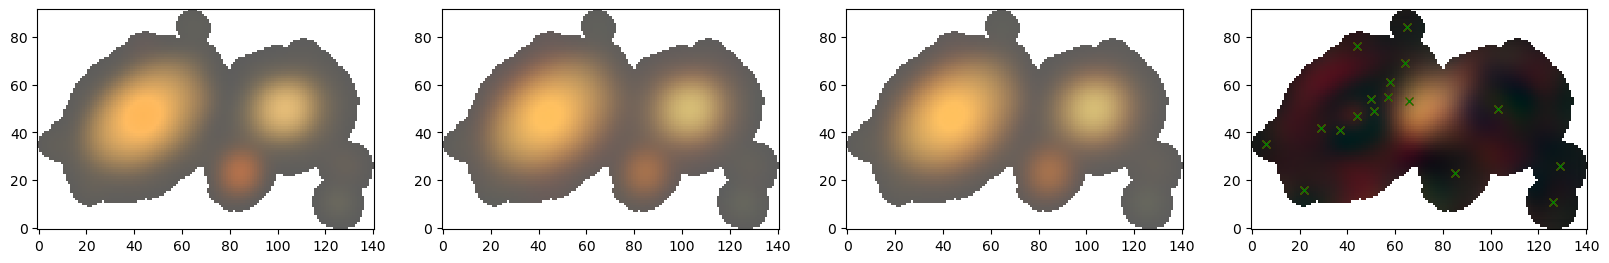

In [3]:
# Use an internal model with a circular Gaussian PSF with sigma=0.8
model_psf = integrated_circular_gaussian(sigma=0.8)
# Create the observation class to hold the data
observation = LiteObservation(images, variance, weights, psfs, model_psf[None, :, :])

# Optimization using ADAM to update parameters
adaprox_init = partial(init_adaprox_component, bg_thresh=0.25, max_prox_iter=1)
# Optimization using FISTA (accelerated proximal gradient method) to update parameters
fista_init = partial(init_fista_component, bg_thresh=0.25)
# For this notebook we just use ADAM, since it gives the best results for all three algorithms for most blends
parameterize = adaprox_init

# Initialize the source morphologies and SEDs
sources = scarlet.lite.init_all_sources_main(observation, centers)
# Convert the components into sources that use the specified parameterization for optimization
sources = parameterize_sources(sources, observation, parameterize)

# Create the blend
blend = LiteBlend(sources, observation)
# Initialization by first using a joint fit for the SEDs
blend.fit_spectra()
# Fit all of the sources in the blend
%time blend.fit(100, min_iter=100)
print(f"{blend.it} iterations to a final -logL of {-blend.loss[-1]:.0f}")

display_multiresolution_residuals(images, mask, blend)

# Using wavelets to calculate the loss function

Using scarlet lite it is fairly straight-forward to update the loss function of the entire model so that instead of calculating the residuals of the model wrt the data in real space, it calculates the starlets (undecimated isotropic wavelets) for the model in each iteration, and compares the residuals of each wavelet scale separately. The idea was that this would be able to supress the high frequency spikes that are seen in the scarlet deconvolved models, but unfortunately it does not appear to work and gives _slightly_ worse results with slightly higher as vanialla scarlet with a higher runtime. 😞

CPU times: user 6.63 s, sys: 943 ms, total: 7.57 s
Wall time: 6.51 s
100 iterations to a final -logL of 24403


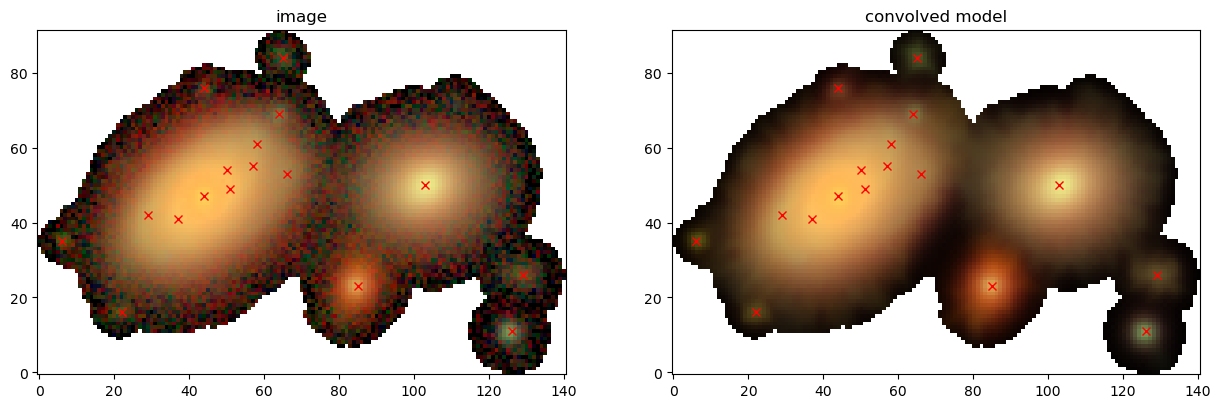

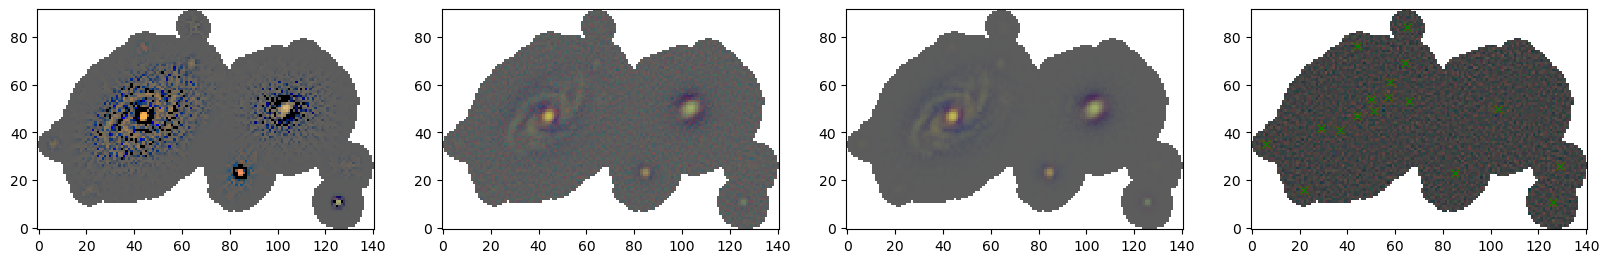

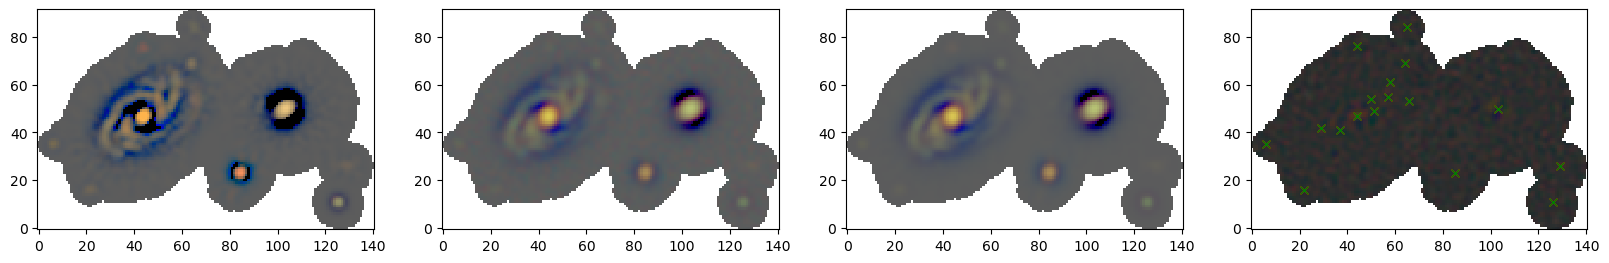

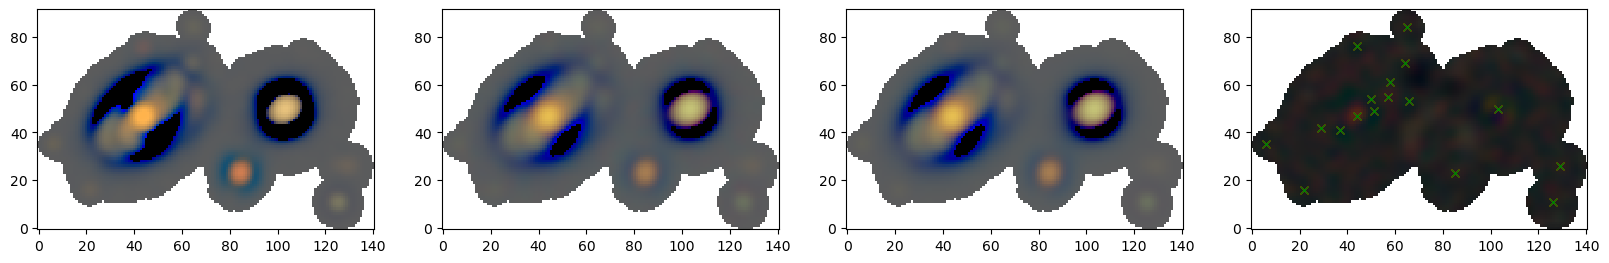

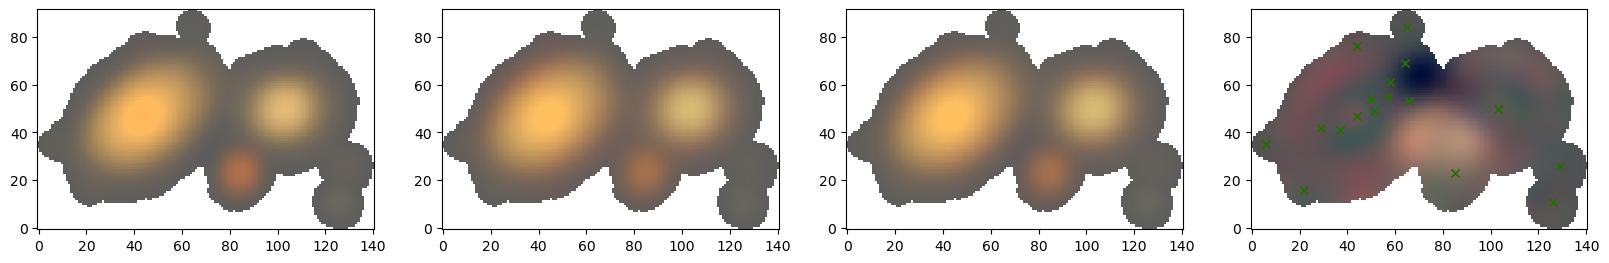

In [4]:
class WaveletBlend(LiteBlend):
    """A Blend that uses the wavelet coefficients to update the logL
    """
    def grad_logL(self):
        # Create the full model with all of the sources
        model = self.get_model(convolve=True)
        
        # Calculate the wavelets in each band
        wavelets = multiband_starlet_transform(model, self.observation.scales, observation.generation)
        
        # Update the loss (used for convergence check)
        self.loss.append(0.5 * -np.sum(self.observation.weights * (self.observation.images - model)**2))
        # Calculate the gradient wrt the model d(logL)/d(model)
        grad_logL = self.observation.weights * (wavelets - self.observation.wavelets)
        grad_logL = np.sum(grad_logL, axis=0)
        grad_logL = self.observation.convolve(grad_logL, grad=True)
        return grad_logL

# Use 3 wavelet scales and a residual image
scales = 3
# Wavelet generation (gen 2 has an extra convolution that takes more time and gives worse results)
generation = 1
# Calculate the image wavelets and attach them to the observation
wavelets = multiband_starlet_transform(images, scales=scales, generation=generation)
observation.scales = scales
observation.wavelets = wavelets
observation.generation = generation

# Initialize the source morphologies and SEDs
sources = scarlet.lite.init_all_sources_main(observation, centers)
# Convert the components into sources that use the specified parameterization for optimization
sources = parameterize_sources(sources, observation, parameterize)

# Create the blend
blend = WaveletBlend(sources, observation)
# Initialization by first using a joint fit for the SEDs
blend.fit_spectra()
# Fit all of the sources in the blend
%time blend.fit(100, min_iter=100)
print(f"{blend.it} iterations to a final -logL of {-blend.loss[-1]:.0f}")

display_multiresolution_residuals(images, mask, blend)

# Use source models with wavelet coefficients

The second test is to use a model for each source that contains wavelet coefficients, where the blend updates the coefficients at each scale with their residuals. The algorithm is similar to Starck et al. 2011 for calculating positive wavelet coefficients, the main difference being that we model each source (set of positive coefficients) separately, using the standard scarlet assumption that each component has a consistent color. However, in this case we allow that color to be different at each wavelet scale.

Unfortunately the result is a worse fit, in more time.

CPU times: user 4.85 s, sys: 0 ns, total: 4.85 s
Wall time: 4.85 s
100 iterations to a final -logL of 71724


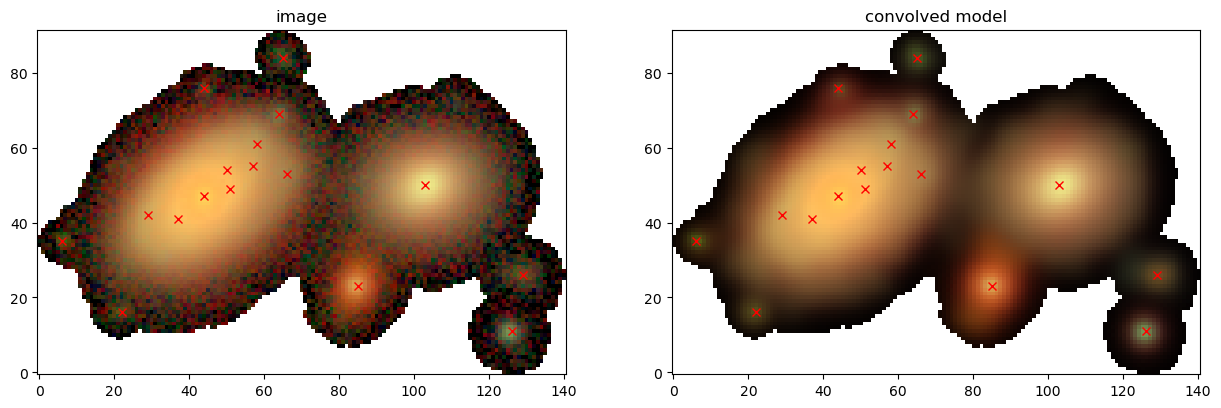

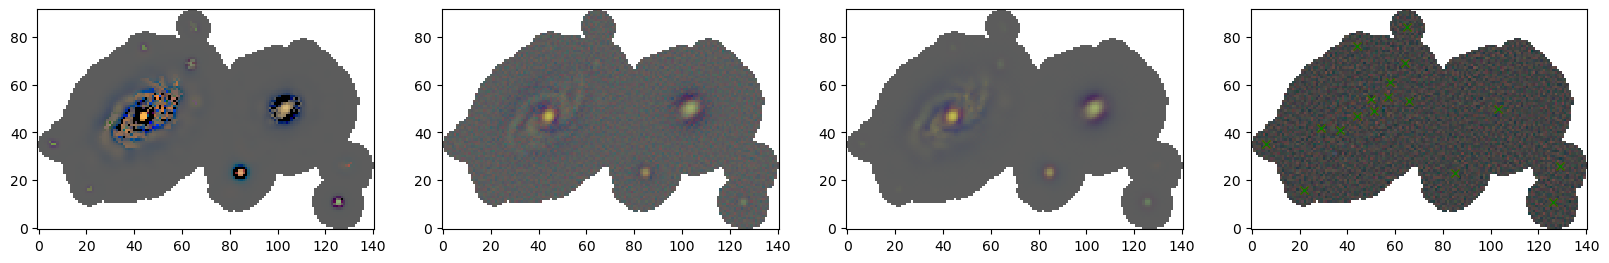

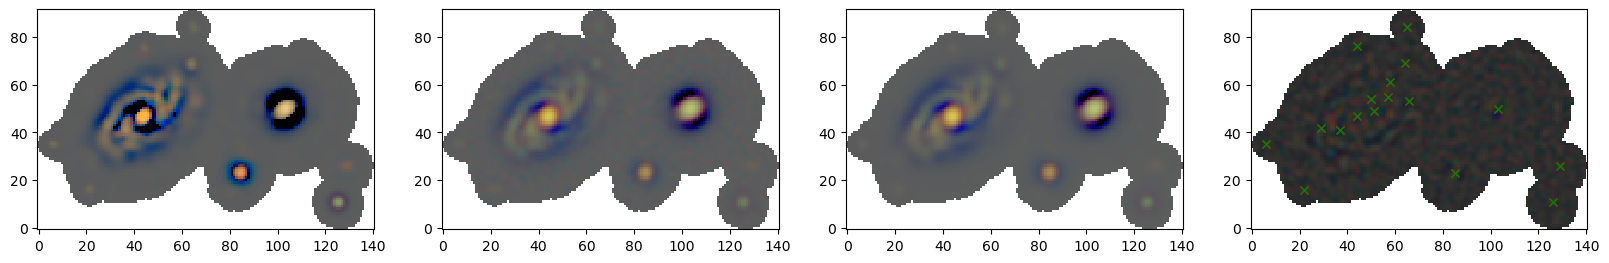

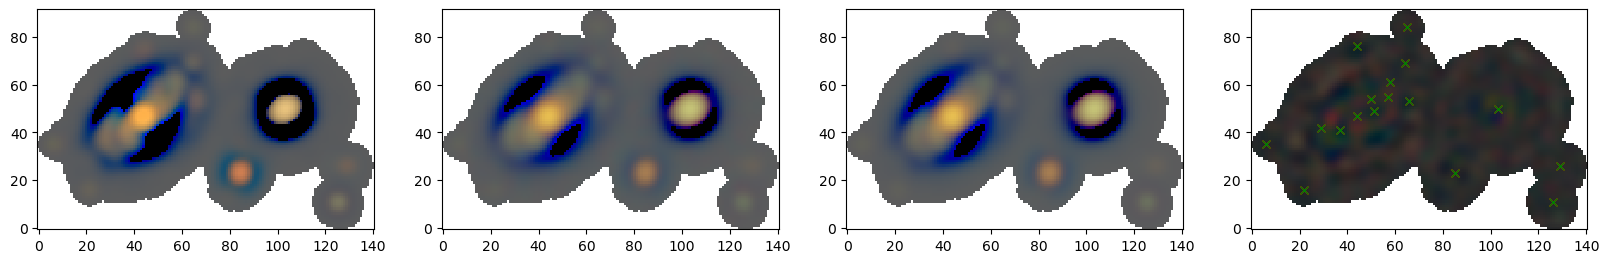

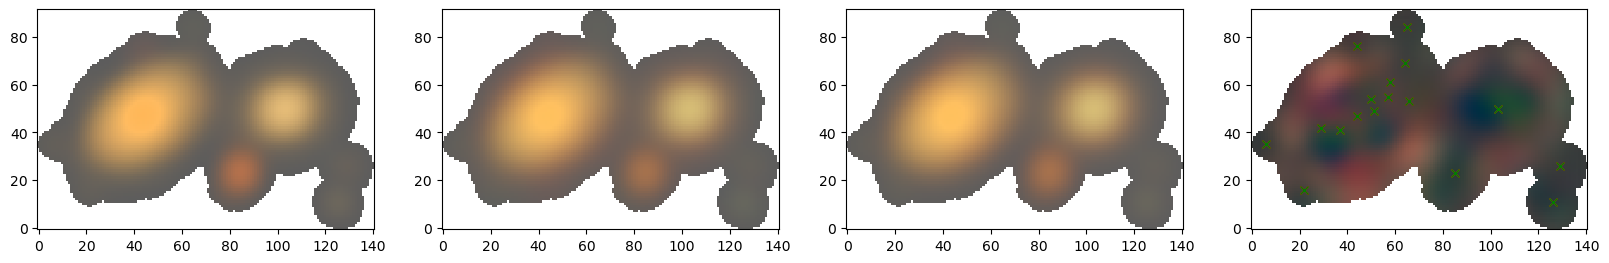

In [5]:
from scarlet.lite import LiteSource, init_monotonic_morph, LiteComponent, project_morph_to_center
from scarlet.wavelet import bspline_convolve
from scarlet.bbox import overlapped_slices, Box
from scarlet.interpolation import get_filter_coords, get_filter_bounds


class StarletConvolution:
    """Convolve a set of starlets with a bicubic spline at each scale
    
    In order to keep each component small and band limited to the
    current scale we perform a separable convolution at each scale
    with the appropriate bicubic spline filter. This class
    keeps track of the filters needed at each scale and their
    application to a set of wavelet coefficients.
    """
    def __init__(self, scales):
        self.scales = scales
        self.filters = {}

        for scale in range(1, scales+1):
            x1 = 2 ** scale
            x2 = 2 ** (scale + 1)
            x = np.linspace(-(x2 - 1), x2 - 1, 2 * x2 - 1)
            y = (np.abs(x - x2) ** 3
                 - 4 * np.abs(x - x1) ** 3
                 +  6 * np.abs(x) ** 3
                 - 4 * np.abs(x + x1) ** 3
                 + np.abs(x + x2) ** 3) / 12
            phi = y / np.sum(y)
            phi_x = phi[None, :]
            phi_y = phi_x.T
            coords = get_filter_coords(phi_x)
            bounds_x = get_filter_bounds(coords.reshape(-1, 2))
            coords = get_filter_coords(phi_y)
            bounds_y = get_filter_bounds(coords.reshape(-1, 2))
            self.filters[scale] = ((phi_y.reshape(-1), phi_x.reshape(-1)), (bounds_y, bounds_x))
    
    def transform(self, wavelets, scale):
        """Transform the wavelet coefficients at a given scale
        """
        from scarlet.operators_pybind11 import apply_filter

        result = np.empty(wavelets.shape, dtype=wavelets.dtype)
        phi, bounds = self.filters[scale]
        # Convolve using the appropriate scale in the y-direction
        apply_filter(
            wavelets.copy(),
            phi[0],
            bounds[0][0],
            bounds[0][1],
            bounds[0][2],
            bounds[0][3],
            result,
        )
        # Convolve using the appropriate scale in the x-direction
        apply_filter(
            result.copy(),
            phi[1],
            bounds[1][0],
            bounds[1][1],
            bounds[1][2],
            bounds[1][3],
            result,
        )
        return result
    
    def transform_single_band(self, wavelets):
        """Transform all of the wavelet coefficients for a single band
        """
        result = wavelets.copy()
        for scale in range(1, wavelets.shape[0]):
            result[scale] = self.transform(wavelets[scale], scale)
        return result
    
    def transform_multiband(self, wavelets):
        """Transform all of the wavelet coeffients, at all scales, in all bands
        """
        result = wavelets.copy()
        for scale in range(1, wavelets.shape[0]):
            for b, w in enumerate(wavelets[scale]):
                result[scale, b] = self.transform(w, scale)
        return result


class WaveletSource(LiteSource):
    """A source modeled as a set of wavelet coeffients
    
    Each component of the source is a set of wavelet
    coefficients, where each component can have its
    own SED (so the SED is allowed to vary by scale).
    """
    def __init__(self, components, dtype, convolution):
        self.components = components
        self.dtype = dtype
        self._flux = None
        self.flux_bbox = None
        self.convolution = convolution
    
    @property
    def scales(self):
        """The number of wavelet scales
        """
        return len(self.components) - 1

    def get_model(self, bbox=None, use_flux=False, stacked=False, transform=True, observation=None):
        """Build the model for the source
        """
        # Use the regular `LiteBlend` where appropriate
        if self.n_components == 0 or use_flux:
            return super().get_model(bbox, use_flux)

        if bbox is None:
            bbox = self.bbox
        model = np.zeros((self.scales+1,) + bbox.shape, dtype=self.dtype)
        for n, component in enumerate(self.components):
            _model = component.get_model()
            slices = overlapped_slices(bbox, component.bbox)
            model[(n,)+slices[0]] += _model[slices[1]]
        
        if transform:
            model = self.convolution.transform_multiband(model)
        
        if not stacked:
            return np.sum(model, axis=0)
        
        if observation is not None:
            assert not stacked
            model = observation.convolve(model)
        
        return model
    
    def update(self, it, grad_logL):
        for scale, component in enumerate(self.components):
            component.update(it, grad_logL[scale])

    def __str__(self):
        return f"WaveletSource<{','.join([str(c) for c in self.components])}>"

    def __repr__(self):
        return f"WaveletSource<{len(self.components)}>"


class WaveletBlend(LiteBlend):
    """A blend composed of `WaveletSource`s
    """
    def __init__(self, sources, observation):
        # The weights used for the wavelet logL
        self.weights = np.array([observation.weights]*len(observation.wavelets))
        # The object used to apply the bspline to each scale
        convolution = StarletConvolution(observation.scales)
        self.convolution = convolution
        # Convert a list of sources to wavelet sources
        wavelet_sources = []
        for source in sources:
            wavelet_sources.append(WaveletSource(source.components, source.dtype, convolution))
        super().__init__(wavelet_sources, observation)
        
        
    def get_model(self, convolve=False, use_flux=False, stacked=False, transform=True):
        """Generate a model of the entire blend"""
        if use_flux:
            return super().get_model(convolve, use_flux)

        # First combine the wavelet coefficients in all scales, in all bands, for all sources
        model = np.zeros((self.observation.scales+1,)+self.bbox.shape, dtype=self.observation.images.dtype)
        for source in self.sources:
            model += source.get_model(bbox=self.bbox, stacked=True, transform=False)
        
        # Transform the wavelet coefficients at each scale, in each band
        if transform:
            model = self.convolution.transform_multiband(model)
        # Recombine the wavelet coefficients into a real space image
        if not stacked:
            model = np.sum(model, axis=0)
        # Convolve each band with the correct difference kernel
        if convolve:
            assert not stacked
            model = self.observation.convolve(model)
        return model
        
    def grad_logL(self):
        """Gradient of the likelihood wrt the unconvolved model"""
        # Get the model at each scale
        model = self.get_model(convolve=True, stacked=False, transform=True)
        # Calculate the wavelet coefficients
        wavelets = multiband_starlet_transform(
            model, scales=self.observation.scales, generation=observation.gen)
        
        # Update the loss
        self.loss.append(0.5 * -np.sum(self.weights * (self.observation.images - model)**2))
        # Calculate the gradient wrt the model d(logL)/d(model)
        _grad_logL = self.weights * (wavelets - self.observation.wavelets)
        grad_logL = np.zeros(_grad_logL.shape, dtype=_grad_logL.dtype)
        for scale, grad in enumerate(_grad_logL):
            grad_logL[scale] = self.observation.convolve(grad, grad=True)
        
        #grad_logL = self.convolution.transform_multiband(grad_logL)
        
        return grad_logL
    
    def fit(self, max_iter, e_rel=1e-4, min_iter=1, resize=10, reweight=False):
        """Fit all of the parameters

        See `LiteBlend` for a description of the parameters.
        """
        it = self.it
        while it < max_iter:
            # Calculate the gradient wrt the on-convolved model
            grad_logL = self.grad_logL()
            # Update each component given the current gradient
            for source in self.sources:
                source.update(it, grad_logL)
            # Check to see if any components need to be resized
            if resize is not None and it > 0 and it % resize == 0:
                for component in self.components:
                    if hasattr(component, "resize"):
                        component.resize()
            # Stopping criteria
            if it > min_iter and np.abs(self.loss[-1] - self.loss[-2]) < e_rel * np.abs(self.loss[-1]):
                break
            it += 1
        self.it = it
        if reweight:
            weight_sources(self)
        return it, self.loss[-1]

def init_wavelet_source(center, observation, wavelets, convolution):
    """Initialize a wavelet source from the observation wavelets
    """
    components = []
    model_psf = observation.model_psf[0]
    py = model_psf.shape[0]//2
    px = model_psf.shape[1]//2
    min_sed = 1e-20
    sed_center = (slice(None), center[0], center[1])
    
    _, morph, bounds = prox_monotonic_mask(wavelets[0], 0, center, max_iter=0)
    bbox = bounds_to_bbox(bounds)
    if bbox.shape == (1, 1) and morph[bbox.slices][0,0] == 0:
        morph = model_psf.copy()
        morph = morph/np.max(morph)
        bbox = Box(model_psf.shape, origin=(center[0]-py, center[1]-px))
    else:
         morph, bbox = project_morph_to_center(morph, center, bbox, observation.bbox[1:])
    
    all_morph = np.array([morph.copy()]*len(observation.wavelets))
    
    for morph in all_morph:
        sed = observation.images[sed_center]
        sed[sed<0] = 0
        if np.all(sed==0):
            sed[:] = min_sed

        components.append(LiteComponent(center, observation.bbox[0] @ bbox, sed, morph))
    
    return WaveletSource(components, observation.images.dtype, convolution)

def init_wavelet_sources(centers, observation):
    """Initialize all of the sources as wavelet sources
    """
    wavelets = np.sum(multiband_starlet_transform(images, scales=scales, generation=1), axis=1)
    wavelets[wavelets<0] = 0
    
    convolution = StarletConvolution(observation.scales)
    
    sources = []
    for center in centers:
        sources.append(init_wavelet_source(center, observation, wavelets, convolution))
    return sources

scales = 2
observation.scales = scales
observation.gen = 2
observation.wavelets = multiband_starlet_transform(images, scales=scales, generation=observation.gen)

# Wavelet sources work better with the FISTA optimization algorithm
parameterize = fista_init

sources = init_wavelet_sources(centers, observation)
sources = parameterize_sources(sources, observation, parameterize)

blend = WaveletBlend(sources, observation)
%time blend.fit(100, min_iter=100)

print(f"{blend.it} iterations to a final -logL of {-blend.loss[-1]:.0f}")

display_multiresolution_residuals(images, mask, blend)